<a href="https://colab.research.google.com/github/wordman2/GINN/blob/main/Praktikum3/GINN_P3_Aufgaben_1_und_2_und_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0.&nbsp; Imports und Helper

In [1]:
!pip install torchinfo

In [2]:
# Imports
import copy

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np

import time
import torch
import torchvision
#import torchvision.datasets as datasets
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import tqdm

import random
import keras.datasets.imdb

from torch.autograd import Variable
from tqdm.auto import tqdm as tqdmauto

In [3]:
def set_seed(seed=None, seed_torch=True):
  """
  Handles variability by controlling sources of randomness
  through set seed values

  Args:
    seed: Integer
      Set the seed value to given integer.
      If no seed, set seed value to random integer in the range 2^32
    seed_torch: Bool
      Seeds the random number generator for all devices to
      offer some guarantees on reproducibility

  Returns:
    Nothing
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
  print(f'Random seed {seed} has been set.')
SEED = 2021
set_seed(seed=SEED)
DEVICE = "cuda"

def zero_grad(params):
  """
  Clear gradients as they accumulate on successive backward calls

  Args:
    params: an iterator over tensors
      i.e., updating the Weights and biases

  Returns:
    Nothing
  """
  for par in params:
    if not(par.grad is None):
      par.grad.data.zero_()


def print_params(model):
  """
  Lists the name and current value of the model's
  named parameters

  Args:
    model: an nn.Module inherited model
      Represents the ML/DL model

  Returns:
    Nothing
  """
  for name, param in model.named_parameters():
    if param.requires_grad:
      print(name, param.data)

def sample_minibatch(input_data, target_data, num_points=100):
  """
  Sample a minibatch of size num_point from the provided input-target data

  Args:
    input_data: Tensor
      Multi-dimensional tensor containing the input data
    target_data: Tensor
      1D tensor containing the class labels
    num_points: Integer
      Number of elements to be included in minibatch with default=100

  Returns:
    batch_inputs: Tensor
      Minibatch inputs
    batch_targets: Tensor
      Minibatch targets
  """
  # Sample a collection of IID indices from the existing data
  batch_indices = np.random.choice(len(input_data), num_points)
  # Use batch_indices to extract entries from the input and target data tensors
  batch_inputs = input_data[batch_indices, :]
  batch_targets = target_data[batch_indices]

  return batch_inputs, batch_targets


def gradient_update(loss, params, lr=1e-3):
  """
  Perform a gradient descent update on a given loss over a collection of parameters

  Args:
    loss: Tensor
      A scalar tensor containing the loss through which the gradient will be computed
    params: List of iterables
      Collection of parameters with respect to which we compute gradients
    lr: Float
      Scalar specifying the learning rate or step-size for the update

  Returns:
    Nothing
  """
  # Clear up gradients as Pytorch automatically accumulates gradients from
  # successive backward calls
  zero_grad(params)

  # Compute gradients on given objective
  loss.backward()

  with torch.no_grad():
    for par in params:
      # Here we work with the 'data' attribute of the parameter rather than the
      # parameter itself.
      # Hence - use the learning rate and the parameter's .grad.data attribute to perform an update
      par.data -= lr * par.grad.data

Random seed 2021 has been set.


In [4]:
(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(num_words=10000, maxlen=250,)
def vectorize_sequences(sequences, dimension=10000):
    # all zero matrix of shape (len(sequences), dimension)
    result = np.zeros((len(sequences), dimension))
    for i,sequence in enumerate(sequences):
        result[i, sequence] = 1
    return result


x_train = vectorize_sequences(x_train)
x_test = vectorize_sequences(x_test)
#x_train = np.expand_dims(x_train, -1)
#x_test = np.expand_dims(x_test, -1)

x_train = Variable(torch.from_numpy(x_train)).float().to(DEVICE)
y_train = Variable(torch.from_numpy(y_train)).long().to(DEVICE)
x_test  = Variable(torch.from_numpy(x_test)).float().to(DEVICE)
y_test  = Variable(torch.from_numpy(y_test)).long().to(DEVICE)

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

17464789/17464789 [==============================] - 1s 0us/step
x_train shape: torch.Size([17121, 10000])
y_train shape: torch.Size([17121])
17121 train samples
17588 test samples


#1.&nbsp; Softmax Implementieren
Implementieren Sie die Softmax Funktion mit Numpy und stellen Sie zunächst sicher, dass diese die selben Ergebnisse liefert wie die Pytorch-Funktion im Beispiel. Vergleichen Sie dann Ihre Implementierungen mit anderen Gruppen und diskutieren Sie auch über Performance und numerische Stabilität. Erstellen Sie ein kleines Benchmark, um Performance und numerische Stabilität zu testen.

In [5]:
#Ihr Code hier
np.random.seed(11)

def softmax(x):
  exp_x = np.exp(x - np.max(x, keepdims=True))  # Subtracting the maximum for numerical stability
  return exp_x / np.sum(exp_x, keepdims=True)


x = np.random.rand(100)

torch_softmax = torch.nn.Softmax(dim=0)
torch_softmax_result = torch_softmax(torch.tensor(x))
own_softmax_result = softmax(x)
np.round(own_softmax_result, 17) == np.round(torch_softmax_result.numpy(), 17)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

Text(0.5, 1.0, "Precision comparison of our softmax and PyTorch's softmax")

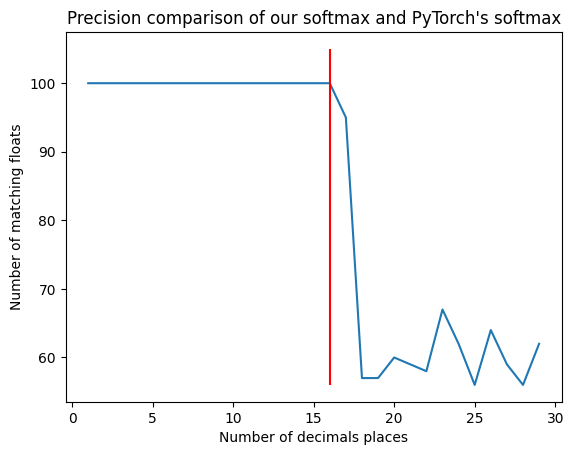

In [40]:
n = 30
num_true_values_by_decimal_place = [sum(np.round(own_softmax_result, i) == np.round(torch_softmax_result.numpy(), i)) for i in range(1,n)]
first_below_100 = np.argmax(np.array(num_true_values_by_decimal_place) < 100)
plt.plot(range(1,n),num_true_values_by_decimal_place)
plt.vlines(first_below_100, ymin=min(num_true_values_by_decimal_place), ymax=105, color="red")
plt.xlabel("Number of decimals places")
plt.ylabel("Number of matching floats")
plt.title("Precision comparison of our softmax and PyTorch's softmax")

In [6]:
%%timeit
#Ihre Benchmarks hier
torch_softmax(torch.tensor(x))

31.2 µs ± 4.12 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [7]:
%%timeit
softmax(x)

29.7 µs ± 6.7 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Bei 16 Nachkommastellen war ein Wert False, bei 15 alle True.

#2.&nbsp; Regularisierung Implementieren

Unten finden Sie einen Pytorch-SGD Schritt mit eingebauter L2-Regularisierung und ohne. Interpretieren Sie die unterschiedlichen Ausgaben. Modifizieren Sie den ersten Codabschnitt mit einer eigenen L2-Regularisierung so, dass identische Ergebnisse erzeugt werden. Sie können dazu die noch nicht verwendete und noch falsch definierte Variable "regtermwrong" umdefinieren und zu einem späteren Zeitpunkt im Code darauf zurückgreifen. ACHTUNG: weight_decay*2=lambda.

In [8]:
#Datendefinition
np.random.seed(123)
np.set_printoptions(8, suppress=True)

x_numpy = np.random.random((3, 4)).astype(np.double)
w_numpy = np.random.random((4, 5)).astype(np.double)
w_numpy[0,0] =9.9
x_torch = torch.tensor(x_numpy, requires_grad=True)


In [47]:
# ohne/eigene Regularisierung
w_torch = torch.tensor(w_numpy, requires_grad=True)
print('Original weights', w_torch)

lr = 0.1
sgd = torch.optim.SGD([w_torch], lr=lr, weight_decay=0)
regtermwrong = max(p.max() for p in w_torch)
regterm = sum(sum([p**2 for p in w_torch]))
y_torch = torch.matmul(x_torch, w_torch)
loss = y_torch.sum() + regterm #


sgd.zero_grad()
loss.backward()
sgd.step()

w_grad = w_torch.grad.data.numpy()
print('0 weight decay', w_torch)

Original weights tensor([[9.9000, 0.0597, 0.3980, 0.7380, 0.1825],
        [0.1755, 0.5316, 0.5318, 0.6344, 0.8494],
        [0.7245, 0.6110, 0.7224, 0.3230, 0.3618],
        [0.2283, 0.2937, 0.6310, 0.0921, 0.4337]], dtype=torch.float64,
       requires_grad=True)
0 weight decay tensor([[ 7.7303, -0.1419,  0.1287,  0.4007, -0.0437],
        [ 0.0302,  0.3151,  0.3153,  0.3974,  0.5694],
        [ 0.4245,  0.3337,  0.4229,  0.1033,  0.1344],
        [-0.0139,  0.0385,  0.3083, -0.1228,  0.1504]], dtype=torch.float64,
       requires_grad=True)


In [10]:
#mit Regularisierung


w_torch = torch.tensor(w_numpy, requires_grad=True)

print('Reset Original weights', w_torch)

sgd = torch.optim.SGD([w_torch], lr=lr, weight_decay=2)

y_torch = torch.matmul(x_torch, w_torch)
loss = y_torch.sum()

sgd.zero_grad()
loss.backward()
sgd.step()

w_grad = w_torch.grad.data.numpy()
print('1 weight decay', w_torch)

Reset Original weights tensor([[9.9000, 0.0597, 0.3980, 0.7380, 0.1825],
        [0.1755, 0.5316, 0.5318, 0.6344, 0.8494],
        [0.7245, 0.6110, 0.7224, 0.3230, 0.3618],
        [0.2283, 0.2937, 0.6310, 0.0921, 0.4337]], dtype=torch.float64,
       requires_grad=True)
1 weight decay tensor([[ 7.7303, -0.1419,  0.1287,  0.4007, -0.0437],
        [ 0.0302,  0.3151,  0.3153,  0.3974,  0.5694],
        [ 0.4245,  0.3337,  0.4229,  0.1033,  0.1344],
        [-0.0139,  0.0385,  0.3083, -0.1228,  0.1504]], dtype=torch.float64,
       requires_grad=True)


Bei dem Code ohne Regularisierung wird nach der Berechnung von x\*W wird das Maximum von x\*W auf alle Elemente in y addiert. Durch die Regularisierung werden nach dem ersten Backward-Schritt große Gewichte stärker reduziert als kleinere Gewichte. Tritt keine Regularisierung ein, bleiben große Gewichte groß, kleine Gewichte klein.

#3.&nbsp; Einfaches MLP in Pytorch
Machen Sie sich ein wenig mit dem IMDB Datensatz und den für Sie erstellten Datenstrukturen in x/y_train/test vertraut.

## 3.1 Modell erstellen und  Angaben zur Modellgröße verstehen
Definieren Sie ein Pytorch Multilayer Perzeptron mit der Größe des IMDB-Dictionaries für one-hot-encodierte Wörte als Eingabe (RELU Aktivierung), 50 Neuronen im Hidden Layer und 2 Ausgabeneuronen. Layer 1 und 2 Ihres Netzes verwendet die Sigmoid-Aktivierungsfunktion, Layer 3 die Softmax-Aktivierungsfunktion.

Generieren Sie Modell-Summary mit torchinfo und erklären Sie, was die ausgegebenen Werte bedeuten und wie diese zustande kommen.

In [60]:
x_train.shape

torch.Size([17121, 10000])

In [75]:
#Ihr Code hier
from torchinfo import summary

class MLP(nn.Module):

  def __init__(self, input_size, hidden_size, output_size):
    super(MLP, self).__init__()

    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size

    self.myModel = nn.Sequential(
        nn.Linear(self.input_size, self.hidden_size),
        nn.Sigmoid(),
        nn.Linear(self.hidden_size, self.hidden_size),
        nn.Sigmoid(),
        nn.Linear(self.hidden_size, self.output_size),
        nn.Softmax()
    )

  def forward(self, x):
    return self.myModel(x)


input_size = x_train.shape[1]
hidden_neurons = 50
output_size = 2
model = MLP(input_size, hidden_neurons, output_size)
batch_size = 1
summary(model, input_size=(batch_size, input_size))

Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [1, 2]                    --
├─Sequential: 1-1                        [1, 2]                    --
│    └─Linear: 2-1                       [1, 50]                   500,050
│    └─Sigmoid: 2-2                      [1, 50]                   --
│    └─Linear: 2-3                       [1, 50]                   2,550
│    └─Sigmoid: 2-4                      [1, 50]                   --
│    └─Linear: 2-5                       [1, 2]                    102
│    └─Softmax: 2-6                      [1, 2]                    --
Total params: 502,702
Trainable params: 502,702
Non-trainable params: 0
Total mult-adds (M): 0.50
Input size (MB): 0.04
Forward/backward pass size (MB): 0.00
Params size (MB): 2.01
Estimated Total Size (MB): 2.05

## 3.2 Modell trainieren und Performancekurven interpretieren
Nutzen Sie den untenstehenden Code um Ihr Modell zu trainieren. Interpretieren und diskutieren Sie die entstehenden Performancekurven. Falls Sie einen unerwarteten Anstieg Ihres Losses beobachten, recherchieren Sie wie Sie diese mit dem Einbau einer einzelnen Verbesserung innerhalb des gegebenen SGD Lernverfahrens beheben können. ACHTUNG: Wenn Sie Ihr Modell nicht oben neu initialisieren, optimieren Sie weiter auf den schon veränderten Parametern.

In [ ]:
EPOCHS  = 291 #@param {type:"slider", min:2, max:1000, step:1}
RATE = 0.902 #@param {type:"slider", min:0.001, max:2, step:0.001}
optimizer = torch.optim.SGD(model.parameters(), lr=RATE, weight_decay=0)
loss_fn   = nn.CrossEntropyLoss()
loss_list     = np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))
accuracy_list_test = np.zeros((EPOCHS,))


for epoch in tqdm.trange(EPOCHS):
    y_pred = model(x_train)
    loss = loss_fn(y_pred, y_train)
    loss_list[epoch] = loss.item()
    #loss = loss_fn(y_pred, y_train)# + 0.01 *l2_reg(model)

    # Zero gradients
    optimizer.zero_grad()

    loss.backward()
    #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)#, args.clip)
    optimizer.step()

    with torch.no_grad():
        y_pred = model(x_train)
        correct = (torch.argmax(y_pred, dim=1) == y_train).type(torch.FloatTensor)
        accuracy_list[epoch] = correct.mean()
        y_pred = model(x_test)
        correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.FloatTensor)
        accuracy_list_test[epoch] = correct.mean()




fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(12, 6), sharex=True)

ax1.plot(accuracy_list)
ax1.set_ylabel("train accuracy")
ax2.plot(loss_list)
ax2.set_ylabel("train loss")
ax3.plot(accuracy_list_test)
ax3.set_ylabel("test acc")
ax3.set_xlabel("epochs");

##3.3.&nbsp;Momentum Implementieren
Vervollständigen Sie Methode momentum_update. Überlegen Sie sich, wie Sie die Korrektheit mit einem Durchlauf inkl. Momentum Update auf Ihrem oben definierten Modell prüfen können

In [ ]:
def momentum_update(loss, params, grad_vel, lr=1e-3, beta=0.8):
  # Clear up gradients as Pytorch automatically accumulates gradients from
  # successive backward calls
  zero_grad(params)
  # Compute gradients on given objective
  loss.backward()

  with torch.no_grad():
    for (par, vel) in zip(params, grad_vel):
      print("Ihr Code hier")


##3.4 Experimente zum Lernverhalten mit Momentum und Batch Size
Im folgenden können Sie für ein festgelegtes Zeitbudget schauen, wie sich der Loss Ihres neuronalen Netzes innerhalb dieser Zeit entwickelt.
Experimentieren Sie zunächst mit den Voreinstellungen mit und ohne Momentum, probieren Sie dann eigene Einstellungen aus. Diskutieren Sie das visualisierte Lernverhalten insbesondere bzgl. unterschiedlicher Batch Sizes.

In [ ]:
@widgets.interact_manual
def minibatch_experiment(batch_sizes='1, 20, 500, 17000',
                         lrs='0.9, 0.9, 0.9, 0.9',
                         time_budget=widgets.Dropdown(options=["0.05", "0.5",  "2.0", "5.0", "7.5"],
                                                      value="5.0"),
                         use_momentum = widgets.ToggleButton(value=True)):

  """
  Demonstration of minibatch experiment

  Args:
    batch_sizes: String
      Size of minibatches
    lrs: String
      Different learning rates
    time_budget: widget dropdown instance
      Different time budgets with default=2.5s

  Returns:
    Nothing
  """
  batch_sizes = [int(s) for s in batch_sizes.split(',')]
  lrs = [float(s) for s in lrs.split(',')]

  LOSS_HIST = {_:[] for _ in batch_sizes}

  #X, y = train_set.data, train_set.targets
  base_model = Model(x_train.shape[1]).to(DEVICE)
  #base_model = MLP(in_dim=784, out_dim=10, hidden_dims=[100, 100])

  for id, batch_size in enumerate(tqdm.auto.tqdm(batch_sizes)):
    start_time = time.time()
    # Create a new copy of the model for each batch size
    model = copy.deepcopy(base_model)
    params = list(model.parameters())
    lr = lrs[id]
    # Fixed budget per choice of batch size
    #initial_vel = [torch.randn_like(p) for p in model.parameters()]
    aux_tensors = [torch.zeros_like(_) for _ in params]
    while (time.time() - start_time) < float(time_budget):
      data, labels = sample_minibatch(x_train, y_train, batch_size)
      loss = loss_fn(model(data), labels)
      if use_momentum:
        momentum_update(loss, params, grad_vel=aux_tensors, lr=lr, beta=0.5)
      else:
        gradient_update(loss, params, lr=lr)
      LOSS_HIST[batch_size].append([time.time() - start_time,
                                    loss.item()])

  fig, axs = plt.subplots(1, len(batch_sizes), figsize=(10, 3))
  for ax, batch_size in zip(axs, batch_sizes):
    plot_data = np.array(LOSS_HIST[batch_size])
    ax.plot(plot_data[:, 0], plot_data[:, 1], label=batch_size,
            alpha=0.8)
    #ax.set_title('Batch size: ' + str(batch_size) + ' #: ' + str(batch_size*len(LOSS_HIST[batch_size])))
    ax.set_title(' #: ' + str(batch_size*len(LOSS_HIST[batch_size])))
    ax.set_xlabel('Seconds')
    ax.set_ylabel('Loss')
  plt.show()
  #return(LOSS_HIST)


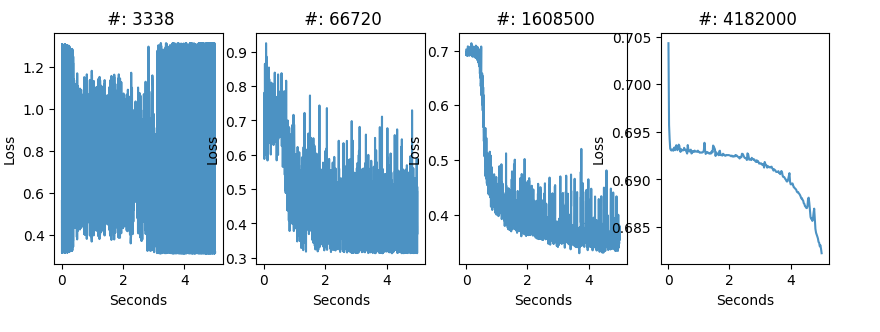